In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import string
from tqdm import tqdm
import re

# Define the model
class GRUTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(GRUTextGenerator, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size

        self.embedding_ff = nn.Linear(vocab_size, embed_size, bias=False)
        self.gru1 = nn.GRU(embed_size, hidden_size, 1, batch_first=True)
        self.gru2 = nn.GRU(hidden_size, hidden_size, 1, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # x: (batch_size, seq_length)
        x = torch.nn.functional.one_hot(x, num_classes=self.vocab_size).float()
        embedded = self.embedding_ff(x)
        x, hidden = self.gru1(embedded, None)  # (batch_size, seq_length, hidden_size)
        x, hidden = self.gru2(x, None)
        logits = self.fc(x)  # (batch_size, seq_length, vocab_size)
        return logits, hidden

token_dict = {letter:i for letter,i in zip(string.ascii_lowercase, range(1,27))}
token_dict[' '] = 0

class TextDataset(Dataset):
    def __init__(self, sentences, idx):
        self.data = []

        self.max_len = max([len(x) for x in sentences])

        for sentence in sentences:
            if len(sentence) > idx:
                x = torch.tensor([token_dict[x] for x in sentence[:idx]], dtype=torch.int64, device=device)
                y = torch.tensor(token_dict[sentence[idx]], dtype=torch.int64, device=device)
                self.data.append((x, y))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

# Training loop
def train(model, dataloaders, vocab_size, device, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.to(device)
    model.train()
    
    for epoch in range(epochs):
        for data_loader in dataloaders:
            total_loss = 0
            for _, (inputs, targets) in enumerate(data_loader, 0):
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                
                logits, _ = model(inputs)  # (batch_size, seq_length, vocab_size)
                logits = logits[:, -1, :]
                logits = logits.view(-1, vocab_size)  # Reshape for loss calculation
                targets = targets.view(-1)  # Reshape to match logits
                
                loss = criterion(logits, targets)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(data_loader)}")


# Example hyperparameters
vocab_size = 27  # a-z and a space character
embed_size = 128
hidden_size = 256
batch_size = 64
seq_length = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the model
model = GRUTextGenerator(vocab_size, embed_size, hidden_size)



In [86]:
# Placeholder: Replace with your own DataLoader
sentences = []
with open("sentences.txt", 'r') as f:
    sentences = f.readlines()
sentences = [re.sub('\W+', ' ', x.lower()).strip() for x in sentences]


<>:5: SyntaxWarning: invalid escape sequence '\W'
<>:5: SyntaxWarning: invalid escape sequence '\W'
/var/folders/bm/yls2l36s0_x_nqfllg6dm5z80000gn/T/ipykernel_3455/2492895047.py:5: SyntaxWarning: invalid escape sequence '\W'
  sentences = [re.sub('\W+', ' ', x.lower()).strip() for x in sentences]


In [ ]:
## Length of alphabet used
print(len(list(set(''.join(sentences)))))

## Number of unique words
print(len(list(' '.join(sentences).split(' '))))
print(len(list(set(' '.join(sentences).split(' ')))))



31
44363
3342


In [95]:
import pandas as pd
import matplotlib.pyplot as plt

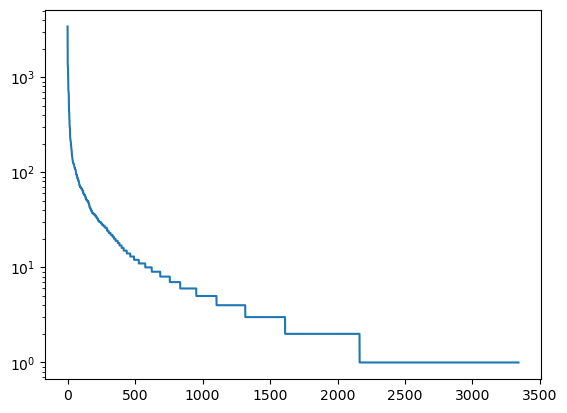

In [97]:
plt.plot(pd.DataFrame(list(' '.join(sentences).split(' '))).value_counts().values)
plt.yscale('log')

In [ ]:
map_dict = {x[0]:y for x,y in 
            pd.DataFrame(list(' '.join(sentences).split(' ')))\
                .value_counts().to_dict().items()}

common_sentences = []

for sentence in sentences:
    good = True

    for word in sentence.split(' '):
        if map_dict[word] < 10:
            good = False
            break
    
    if good:
        common_sentences.append(sentence)

common_sentences = list(set(common_sentences))

In [ ]:
common_sentences 

In [112]:
len(common_sentences)

3695

In [ ]:

dataloaders = []
for i in range(1, max([len(x) for x in sentences])):
    dataset = TextDataset(sentences, i)
    dataloaders.append(DataLoader(dataset, batch_size))

# Example training call
train(model, dataloaders, vocab_size, device)

In [58]:
def vectorise(sentence):
    return torch.tensor([token_dict[x] for x in sentence], dtype=torch.int64, device=device)

def run_inference(model, sentence):
    input = vectorise(sentence)

    output = model(input)

    logits = output[0][-1,:]

    print(logits)

    max_idx = logits.argmax().item()
    for a, i in token_dict.items():
        if max_idx == i:
            sentence += a
            return sentence
    
    print(max_idx)



sentence = 'a dog ru'

In [54]:
for i in range(12):
    sentence = run_inference(model, sentence)
    print(sentence)
    break

tensor([-2.9654e+00,  3.3953e+00, -1.4307e+00, -4.1284e-01, -7.9363e-01,
        -5.2193e-01, -5.8328e+00,  2.0428e-01, -9.2972e+00, -1.4741e+00,
        -5.2937e-01,  4.0453e+00,  4.3836e+00,  6.6509e+00,  2.0651e+01,
        -7.7552e-01,  3.2460e+00, -6.7695e+00, -3.4690e-01,  4.6739e+00,
         5.1691e+00,  6.9649e-01, -2.1370e+00, -1.7458e-02, -6.3181e+00,
         2.6114e+00, -6.0107e+00], grad_fn=<SliceBackward0>)
a dog run


In [59]:
import numpy as np
import json
from json import JSONEncoder


In [60]:
class EncodeTensor(JSONEncoder,Dataset):
    def default(self, obj):
        if isinstance(obj, torch.Tensor):
            return obj.cpu().detach().numpy().tolist()
        return super(json.NpEncoder, self).default(obj)


In [61]:
x = vectorise(sentence)
y = model(x)[0]

np.savetxt('test_data/generative_gru_x.csv', x.detach(), delimiter=',')
np.savetxt('test_data/generative_gru_y.csv', y.detach(), delimiter=',')

with open('models/generative_gru.json', 'w') as json_file:
    json.dump(model.state_dict(), json_file,cls=EncodeTensor)
